In [1]:
!pip install google_trans_new

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import google_trans_new

In [3]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/luobingqiao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/luobingqiao/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/luobingqiao/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/luobingqiao/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [72]:
df = pd.read_csv('../Datasets/cleaned_reviews.csv')

In [73]:
df.columns

Index(['Unnamed: 0', 'reviewer_id', 'listing_id', 'date', 'reviewer_name',
       'comments', 'name', 'description', 'neighborhood_overview', 'host_id',
       'host_since', 'host_about', 'host_response_time', 'host_response_rate',
       'host_is_superhost', 'host_neighbourhood', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights',
       'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'calendar_updated',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews', 'number_of_reviews_ltm',
       'review_scores_rating', 'review_scores_accuracy',
       

In [74]:
df.head()

,Unnamed: 0,reviewer_id,listing_id,date,reviewer_name,comments,name,description,neighborhood_overview,host_id,...,review_scores_value,instant_bookable,calculated_host_listings_count,reviews_per_month,polarity_score,sentiment,nearby_sites_rating,nearest_station_dist,nearest_site_dist,nearest_site_rating
0,0,8557223,49091,2013-10-21,Jared,Fran was absolutely gracious and welcoming. Ma...,COZICOMFORT LONG TERM STAY ROOM 2,This is Room No. 2.(available after Jan 15 201...,NaN,266763,...,8.0,f,2,0.02,0.9615,pos,0.995731,0.617762,4.295315,4.595264
1,1,1356099,50646,2014-04-18,James,A comfortable room in a smart condo developmen...,Pleasant Room along Bukit Timah,Fully furnished bedroom with a nice view on th...,The serenity & quiet surrounding makes it an i...,227796,...,9.0,f,1,0.30,0.9484,pos,1.269606,0.399696,2.039236,4.654423
2,2,15222393,50646,2014-06-05,Welli,Stayed over at Sujatha's house for 3 good nigh...,Pleasant Room along Bukit Timah,Fully furnished bedroom with a nice view on th...,The serenity & quiet surrounding makes it an i...,227796,...,9.0,f,1,0.30,0.9879,pos,1.269606,0.399696,2.039236,4.654423
3,3,5543172,50646,2014-07-02,Cyril,It's been a lovely stay at Sujatha's. The room...,Pleasant Room along Bukit Timah,Fully furnished bedroom with a nice view on th...,The serenity & quiet surrounding makes it an i...,227796,...,9.0,f,1,0.30,0.9627,pos,1.269606,0.399696,2.039236,4.654423
4,4,817532,50646,2014-07-08,Jake,"We had a great experience. A nice place, an am...",Pleasant Room along Bukit Timah,Fully furnished bedroom with a nice view on th...,The serenity & quiet surrounding makes it an i...,227796,...,9.0,f,1,0.30,0.9274,pos,1.269606,0.399696,2.039236,4.654423


In [75]:
df.comments.isna().value_counts()

False    130633
True          1
Name: comments, dtype: int64

In [76]:
df.comments.fillna('',inplace=True)

In [77]:
df.comments[0]

'Fran was absolutely gracious and welcoming. Made my stay a great experience. Would definitely recommend this cozy and peaceful place to anyone.'

### Clear some unprocessable comments
There are automated replies like _'the host canceled the reservation the day before arrival. This is an automated posting'_. Host cancellation has already been considered in the cleaned listing dataset. Thus we omit them here.

In [78]:
cancel_post = 'This is an automated posting'

df = df[[cancel_post not in text for text in df.comments]]

In [79]:
df.shape

(130634, 62)

#### Utility function: Detect foreign languages and translate them into English

In [80]:
from google_trans_new import google_translator 
translator = google_translator() 

def detectandtranslate(texts):
    trans = pd.DataFrame(index=texts.index,columns=['text'])
    non_eng_count = 0
    for i in texts.index:
        text = texts[i]
        detect_res = translator.detect(text)
        if not detect_res:
            trans.loc[i,'text'] = ''
        elif translator.detect(text)[1] != 'english':
            non_eng_count += 1
            trans.loc[i,'text'] = translator.translate(text,lang_tgt='en')
        else:
            trans.loc[i,'text'] = text
    return non_eng_count / len(texts), trans

### 1. Tokenize the text and extract most frequent words

In [81]:
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.corpus import stopwords

def tokenizer(text):
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    return(text)

vectorizer = TfidfVectorizer(stop_words='english',
                             ngram_range=(1,2),
                             max_df = 0.5,
                             tokenizer=tokenizer,
                             max_features=200)
X = vectorizer.fit_transform(df.comments)

In [82]:
print(vectorizer.get_feature_names())

['access', 'accommodating', 'air', 'airbnb', 'airport', 'amazing', 'amenities', 'apartment', 'area', 'arrived', 'available', 'away', 'awesome', 'bathroom', 'beautiful', 'bed', 'bedroom', 'best', 'better', 'big', 'bit', 'book', 'breakfast', 'building', 'bus', 'bus stop', 'center', 'central', 'centre', 'check', 'check-in', 'chinatown', 'city', 'clean', 'close', 'close mrt', 'come', 'comfortable', 'communication', 'condo', 'convenient', 'cozy', 'day', 'days', 'definitely', 'definitely recommend', 'distance', 'door', 'easily', 'easy', 'enjoyed', 'enjoyed stay', 'especially', 'exactly', 'excellent', 'experience', 'extremely', 'facilities', 'family', 'fantastic', 'far', 'fast', 'feel', 'felt', 'flat', 'floor', 'food', 'friendly', 'friends', 'gave', 'good', 'good location', 'good place', 'got', 'great', 'great host', 'great location', 'great place', 'great stay', 'guests', 'help', 'helpful', 'highly', 'highly recommend', 'highly recommended', 'home', 'hospitality', 'host', 'hosts', 'hotel', '

### 2. Using Vader Model
Reasons for choosing this model:<br>
1. From the NLTK package, Vadar model is trained with **website comments and reviews**, making itself suitable for this senario.
2. It is exceptionally good at dealing with **sentences with mixed sentiments** and rate a compounded score.
3. It accounts for many **acronyms, slangs, Capitalized Words and even emojis** that are recently prevalent on the Internet.
4. Rule-based model makes it **easily adjustable**.

In [83]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [84]:
sid = SentimentIntensityAnalyzer()
newWords = {'amenities': 0.5, 'big': 0.5, 'bus': 0.5,'near':0.5,'nearby':0.5,'quiet':0.5,'quick':0.5,'spacious':0.5,'responsive':0.5,
    'family':0.5,'close':0.5,'room clean':0.5,'hospitality':0.5,'accessible':0.5,'affordable':0.5,'high':0.5,'shopping':0.5,'dining':0.5,'exactly':0.5}
sid.lexicon.update(newWords)

In [85]:
def get_sentiment(text, sid):
    return sid.polarity_scores(text)['compound']

In [86]:
df['polarity_score'] = [get_sentiment(text,sid) for text in df.comments]
df['polarity_score'].describe()

count    130634.000000
mean          0.757179
std           0.314749
min          -0.995800
25%           0.680800
50%           0.875000
75%           0.950400
max           0.999800
Name: polarity_score, dtype: float64

<ipython-input-87-5efb92ba86a4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full['count'] = 1


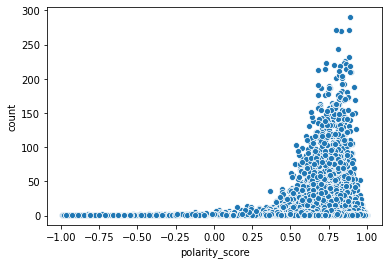

In [87]:
df_full = df[['polarity_score','listing_id']]
df_full['count'] = 1
df_full = df_full.groupby(['listing_id']).agg({'polarity_score':'mean', 'count':'count'})
sns.scatterplot('polarity_score', 'count', data=df_full);

In [88]:
df.loc[df.polarity_score >= 0.5,['reviewer_id','comments','polarity_score']].sample(20).style.bar(subset=['polarity_score'], align='mid', color=['#d65f5f', '#5fba7d'])

,reviewer_id,comments,polarity_score
91788,228875042,"Superb cosy little condo with a nice terrace which is rare. Nice secure condo block. Only 1 minute walk to Aljunied MRT which is only a few stops from airport in one direction. And only a few stops to the city Center. Alee and Johnny are great hosts and easily contactable via (Hidden by Airbnb) . Will definitely try to book on future trips. Food loft at end of road has a great place called Collins Grill Bento, great food too",0.975400
92026,695139,Amazing place to stay with great location.,0.836000
39862,4175250,Highly recommend Ruth's place to stay in Singapore. Location is close to 2 MRT stations and to a great chicken rice place called Boon Tong Kee. Unit is clean and it has a great swimming pool! Highly recommend.,0.953700
29087,190290997,Very good location central to everything tourists visitors need make their stay their visit worthwhile..safe friendly comfortable place.,0.865500
73308,20715591,"our group had a really good time here. very quiet and convenient location, clean and comfy space!",0.789300
15648,46639444,Hello Alex and team. Thanx so much for the great experience. The place was just as promised. No exception. What I liked most was the non-intrusive and efficient way in which the transaction and the stay was executed. Responses were quick and helpful. I got a late checkout which was helpful as I had a late evening flight. Delighted and will highly recommend. It was my first experience with Air BnB and the whole process was surprisingly delightful. Cheers!,0.984300
51657,187577241,"great place, pleasant experience during our stay",0.812600
28773,147134678,"Clean, nice, and have everything we need.",0.670500
73073,42145766,"A truly lovely location for a great price. It is right on the MRT line, which makes it easy to get downtown, but it's fun walking around the neighborhood too. The hawker center outside the Airbnb has great, cheap food - I highly recommend the thosai place a few shops down. The host made it very easy for us to have a lovely stay with prompt responses and thoughtful amenities within the room.",0.989000
104667,39023579,"Sarah is very responsive in the questions we sent her and she will try to cater to our needs. The space is very private and near it’s near bbq pit. We had an enjoyable picnic under the stars. It would be more fun to go as a group and I think couple can be quite boring. Nothing much to explore and I would advice bring picnic mat and games, the sand is clean and soft. You should wake up early for sunrise. Toilet is near and Carpark g is just behind.",0.893000


In [93]:
df.loc[df.polarity_score < 0,['reviewer_id','comments','polarity_score']].sample(20).style.bar(subset=['polarity_score'], align='mid', color=['#d65f5f', '#5fba7d'])


,reviewer_id,comments,polarity_score
28406,30325162,The host was really helpfull although we didn't talk a lot. Nice place for a short stay in Singapore. You got what you pay for.,-0.408200
94920,55535911,Difficult access and very narrow staircase to the room which highly not recommended for kids and elders for safety purposes.,-0.145700
55032,11856071,Der Aufenthalt bei Nan war schön. Sie war sehr freundlich. Die Wohnung ist ziemlich klein und einfach ausgestattet. Alles war sauber und wie beschrieben.,-0.948500
51245,75668089,The host is lovely and he did try to deal with my complaint about being woken repeatedly from people cooking and washing late at night and showering at midnight. It’s not somewhere I’d recommend unless your a backpacker for instance and it was really quite dirty and the bathroom tap was broken. The sheet was clean on my bed but that’s about it I’m afraid. Perhaps the family rooms were better but room 4 a disaster as right beside bathroom and if you need to go when someone having a long shower then you have to hold on. I did see a bathroom upstairs when I was leaving but I assume that for for the upstairs rooms use. In saying that there is signs saying no cooking after 10.30 pm or using washing machine after 8 pm so I guess that is hard to control as some people are just extremely inconsiderate and he was absolutely lovely but overall just not a pleasant experience.,-0.851300
101066,225313,The booking was canceled on the day we were to check in. Sent several messages the day before which was left unanswered. Will never book this ever again. Very frustrating and disappointing. Booked a hotel instead.,-0.768800
20703,200946819,No comments,-0.296000
121045,322258220,"Sehr herzlicher Empfang durch die Haushilfe. Es wurde uns alles , trotz geringen Englisch Kenntnissen unsererseits, alles super gut erklärt und gezeigt. Die Unterkunft liegt etwas abseits der Stadt, aber mit Bus und U Bahn ist alles gut erreichbar.",-0.526700
92758,160542519,"Apart from the dried blood on the bed clothes, it was clean. Don’t get my wrong, the linen was clean...but old blood puddles throughout weren’t inviting...",-0.102700
81862,5156582,The external location of the house is not good. We had to walk beside an open drain to go to the entrance to the house which was a back unit.,-0.341200
110063,197248661,We have been cheated with a different listing from the given picture with a smaller and cramped unit. The bedsheets keep shifting as it does fit properly (no fitted sheets). Only has 1 double bed and 4 single beds.,-0.202300


There are many **non-english comments** that received **inaccurate scores**.

In [94]:
df[df.polarity_score == 0].shape[0]

1

We discard the posts with neutral sentiments as majority of them were written in foreign languages or not meaningful. 

In [95]:
df_eng = df[df.polarity_score != 0]

In [96]:
df_eng.loc[df_eng.polarity_score <= -0.5,['reviewer_id','comments','polarity_score']].sample(20).style.bar(subset=['polarity_score'], align='mid', color=['#d65f5f', '#5fba7d'])


,reviewer_id,comments,polarity_score
127955,34795464,"We stayed here for almost 2 months. The property wasn't accurate. When we arrived, the entire place smelled like cigarettes and the floors were dirty. The host wouldn't do anything about it and wouldn't even offer a discount for the inconvenience. Wifi wasn't great either and was spotty. It took a few weeks of complaining to the host to finally send someone over to fix the wifi. Overall, the host didn't provide a great service to us even though we were long term tenants.",-0.883100
13227,140921505,"It is a pretty huge but old unit, however with the listing price should be consider affordable. Problems: 1. The living room air-con unit is workable despite it has a really bad water leakage problem, till to the extend that we have to use a water pail to contain the water leakage. 2. The toilet at the lower level has a faulty shower head which is not useable. 3. Has also encountered problem with the opening of the main entrance sliding door which resulting in our friend had to wait outside for 30min. Unsure if it is caused by intermittent faulty door lock/latch. All issues have not been communicated to us, or at least i felt the owner should check and ensure the house appliances/facility is tested serviceable before leasing for short stay. As such, i felt pretty disappointed.",-0.927900
33445,69692150,Prakash war ein guter Gastgeber. Er hat uns sehr gut informiert so dass wir gut zurecht kamen. Die ganze Wohnung stand uns zur Verfügung. Wir haben uns sehr wohl gefühlt und prima geschlafen. Prakash gab uns gute Tips für unseren Tag in Singapur. Nur schade dass wir ihn vor der Abreise nicht mehr gesehen haben um uns persönlich zu verabschieden.,-0.831600
76762,218373837,"Ari und seine Mama waren super liebe gastfreundliche Menschen, bei denen wir uns gut aufgehoben gefühlt haben. Das Bad war leider nicht ganz so sauber aber es war zu verkraften. Ansonsten ein moderner Stil wie auf den Fotos. Die Lage der Unterkunft ist leider etwas außerhalb gelegen, mit der MRT brauchten wir ins Zentrum mehr als eine Stunde.",-0.906200
41379,36490437,"Das ist ein Apartment der Superlative und in Singapur eine echte Rarität. Top-Lage, überdurchschnittlich groß, sehr sauber und modern, super ausgestattete Küche, grandiose Fensterfront mit Blick auf die Umgebung, kleiner Pool vor der Wohnung, sehr sauberes, gut gepflegtes Apartment-Haus, viele Restaurants und Einkaufsmöglichkeiten in unmittelbarer Nachbarschaft. Und das Eindrucksvollste: Rowena ist eine fantastische Gastgeberin, die über (Hidden by Airbnb) permanent Kontakt hält und immer für Fragen und Tipps bereit steht.",-0.599400
2998,26885579,"location is great.very convenient to go to any place and get food.but the equipment in bathroom and toliet is not as good as I think.I use the bathroom three times,I get into a blocking bathroom two of them.And not the same one.The bed on top is not easy to get on it.I want to move to a lower bed,the reception told me that there is no empty bed at that night.Actually,there are two empty beds.",-0.883700
14109,22317084,Not worth it. At all. The room is EXTREMELY noisy. Very thin walls. You’ll hear everything. And if the washer and dryer are on downstairs you’ll never sleep from the banging noise. Check in process not the greatest. And I suggest you look up the exact location of the nearest metro station first because you WILL walk. And finally - someone was in the room before I checked out and I don’t appreciate that. I’m not spoiled and I travel a lot. And I’m very disappointed in this one.,-0.815300
43943,31983113,"Das Zimmer war sehr sauber und geräumig. Sowohl die Besitzer als auch die Haushälterin waren sehr freundlich und hilfsbereit. Mit dem Bus 16 ist man in knapp 10 min bei Bedok MRT, mit dem Bus 36 in knapp einer halben Stunde in der Innenstadt.",-0.893400
36368,200579502,Lousy service especially the cleaniness of the room. And yet I notice that before we checking there's a charge of $49. Its too

Some of extremely negative posts were **not written in English**.<br>
So let's **translate them back into English** and **reassign them the sentiment score**.

In [97]:
non_english_portion, translated_text = detectandtranslate(df_eng.comments[(df_eng.polarity_score <= -0.95)])

In [98]:
print('{0:.2f}% of the texts are non-english\n'.format(non_english_portion*100))

0.00% of the texts are non-english



In [99]:
for ind in df_eng[df_eng.polarity_score <= -0.95].index:
    df_eng.comments[ind] = translated_text.text[ind]
    df_eng.polarity_score[ind] = get_sentiment(translated_text.text[ind],sid)

<ipython-input-99-992c49a0a6c8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eng.comments[ind] = translated_text.text[ind]
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3417: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
<ipython-input-99-992c49a0a6c8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eng.polarity

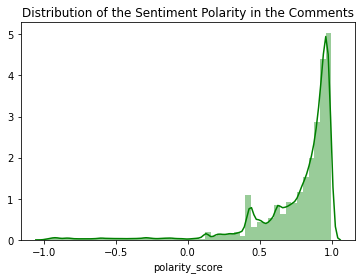

In [100]:
sns.distplot(df_eng['polarity_score'], norm_hist=True, color='g')
plt.title('Distribution of the Sentiment Polarity in the Comments');

In [101]:
def getsentiment(score):
    if score>=0:
        return 'pos'
    else:
        return 'neg'
df_eng['sentiment'] = df_eng['polarity_score'].apply(getsentiment)

<ipython-input-101-3b4ced7f6eaa>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eng['sentiment'] = df_eng['polarity_score'].apply(getsentiment)


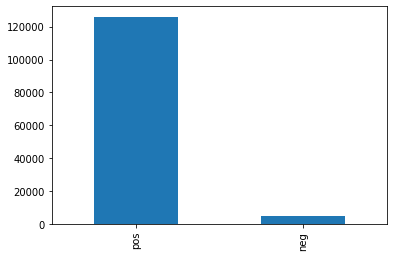

In [102]:
df_eng['sentiment'].value_counts().plot(kind='bar')

In [103]:
df_eng.loc[df_eng.polarity_score >= 0.5,['reviewer_id','comments','polarity_score']].sample(20).style.bar(subset=['polarity_score'], align='mid', color=['#d65f5f', '#5fba7d'])


,reviewer_id,comments,polarity_score
22816,17581310,"The house is quite clean and tidy. Location is great just at the seashore, and the sea view is awesome (but please do not come to SG in August and September because of the fog..) Easy to get taxi and there is shuttle bus to MTR. Simple food just across the street. Ronnie and his wife are both very nice.",0.963700
51020,119496518,Great location,0.624900
77780,215307322,immediately felt like home! very cute house! definitely will come back! apart from we were not informed about the wifi and dryer spoil by the previous guest! i love the place! thumbs up!!,0.934000
6637,12224499,"Darrick's place is located in a very good spot in Singapore, only 10 min walk from the subway. There wasn't any communication from him, just an airbnb instruction to ring the bell for staff to let you in the building. Nevertheless, checkin and checkout was very easy. The stay was very comfortable.",0.874400
58300,18479695,"We stayed here for 2 nights. Pros: - host is very responsive - assistant in the place is very helpful and lives within the same house so you can always knock on her door whenever you need something - location is good, very near Little India and Little India MRT. There are also restaurants right at the corner of the street. - Checkin is very fast, host will provide a door passcode. - Aircon and WIFI - Superb! - Kitchen is well maintained with provided utensils. Cons: - Toilet is not within the room but shower is. - The room is not cleaned on a daily basis but I think you can ask.",0.801000
83574,12967408,"We stayed in the Oslo room which is the smallest of the rooms at this shophouse. The room is tastefully decorated with a work desk that has a mirror so can double as a makeup table for women. Room is on the small side but is made up by the large bathroom with rainfall shower head. Couple of other things to be aware of. The room has windows that don't open and are frosted so you can daylight coming in but no view of the outside. This room faces the street so you'll get street noise. Best to bring a good set of ear plugs which we did so noise wasn't a problem. Lots of good food choices nearby on Geylang Road as well as the famous Old Airport Road hawker center (a 10 - 15 minute walk). There're grocery stores and a 7-11 (near the MRT station) to get your supplies. Like in the description, MRT is 7 - 10 minutes walk.",0.970700
10498,16960146,"Great value, clean and conveniently located. There's construction just behind the building, so it can be quite noisy during the day. The WiFi signal is horrible, it constantly disconnects.",0.572900
79207,122795853,Nice house. Nice location. Safe neighbor. But unfortunately Darren lieing about they still play poker in the midnight until 6am. The room is one window next to living room. I can't sleep whole night.. Except that.. The room is fine.,0.851900
19744,10765014,Elise's spacious studio was close to the MRT and Little India. The springy mattress was a little bit uncomfortable but otherwise we had a great stay!,0.777000
45652,100113974,"Attari was my first Airbnb host, and he went out of his way to facilitate my staycation over at his place. He was easily accessible and responsive when my girlfriend and I needed to leave the house or to borrow some utensils from him. I did enjoy my first Airbnb experience over at his place and I look forward to more experiences in time to come.",0.750600


In [104]:
df_eng.loc[df_eng.polarity_score <= -0.4,['reviewer_id','comments','polarity_score']].sample(20).style.bar(subset=['polarity_score'], align='mid', color=['#d65f5f', '#5fba7d'])


,reviewer_id,comments,polarity_score
14062,28982003,"Das Zimmer war sauber und sehr zentral gelegen. Es war zwar etwas klein, aber für einen kurzen City-Trip vollkommen ausreichend.",-0.831600
11783,1388116,"The check in was very easy and there were no problems. But there is a really loud construction site next to the room ans from 8am-10pm it is like hell out there. Appartment was ok, but the linen were a bit dirty and the toilet wasn't cleaned (dried pee on the lid). The surrounding area is not really nice (dirty, loud, unsave, prostitution, bad food). First time I am not really satisfied with airbnb...",-0.952000
13129,61337689,"during stay, there were some amenity problems such as leakage of aircon and internet/wifi disconnection. they shared the modem with the neighbours. The problem is, the modem is installed/located in the neighbours unit, so when the neighbours left their unit then the modem will be automatically off. it was a bit annoying.",-0.690800
109913,282333668,"Instructions were fantastic. Not once did I have to contact the host. The host was willing to move the check-out time to accommodate me. The host contacted me immediately and maintained that open communication with me throughout the process. Cleanliness needs improvement. When I arrived, I found water on the toilet seat, as if someone had use the bidet but had not bothered to clean up after themselves. There was dirt or some kind of debris on the kitchen counter. There were a lot of small flying insects in the bathroom. At first they mostly congregated at the corners of the ceiling but once I turned on the shower they would start flying. Some would periodically land on me. Throughout the apartment: there was a serious ant problem. On the floor, on the table, in the kitchen, etc. They were everywhere. I had to shake my clothes and belongings because of the ants and the flies. There was a lot of noise because of the local businesses, but it stopped around 1 or 2 am.",-0.824500
129724,140682716,"BEWARE!!! Room is totallly difference from picture!!!! This owener using another room type to misleading customer. I saw some complaint commend and i still believe on the host and send message to confirm. The host telling me the room is exact as the the picture shown but end up told me that is advertising purpose during the day i reach the room. Theroom is super duper much smaller than the picture showing.Many kitchenware is not available,bathroom no clean. The picture show in the airbnb app is family suite room, not the king size room which is much smaller as one small chair can fill the gap between bathroom and kitchen. Host initally still dont allow us to take photo unless we pay the deposit and agreed to check in. after that another owener Joanne only allow us to take room picture and report to airbnb. I try to ask refund from host but she not allow and mention she didnt did wrong. However airbnb staff mention host using fake picture to misleading customer in the room size is not consider for refund.i am shock airbnb to allow host cheated customer, maybe only owner is thier customer, tenant was not. In the end i just leave this terrible room and book another hotel. my booking for 2 days 170sgd just a good leasson for me . Beware also this SNOW owener is same group with the JOANNE owner!!! Dont be the next one cheated by them!!!",-0.963700
96351,31768513,"We were at the designated place at the right time but they were 30 minutes late. When we got in the place, it was still being cleaned for 1 hour more. When we were out already, the host kept calling and we found out that we have to be transferred. We got back at around 9pm, transferred to this other place and it was also being cleaned. We still have to wait for 1 hour again for them to finish cleaning. As they were cleaning, there were cockroaches everywhere! The place had no curtains for privacy and the air conditioning unit in one room was not working. The TV remote had no batteries. The four of us had to sque

In [105]:
df_eng.to_csv('../Datasets/cleaned_senti_reviews.csv')